In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poojasasikumar","key":"282f536ea08093c9f4f656abb52a81ba"}'}

In [ ]:
import os
import shutil

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set the permissions of the kaggle.json file
os.chmod('/root/.kaggle/kaggle.json', 600)


In [ ]:
# Define the path where you want to save the dataset in your Google Drive
dataset_path = '/content/drive/MyDrive/eye_diseases_classification'

# Create the directory if it doesn't exist
os.makedirs(dataset_path, exist_ok=True)

# Change the current working directory to the dataset path
os.chdir(dataset_path)

# Download the dataset using Kaggle API
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

# Unzip the downloaded dataset
!unzip eye-diseases-classification.zip -d .

# Optionally, remove the zip file to save space
os.remove('eye-diseases-classification.zip')


Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
Archive:  eye-diseases-classification.zip
  inflating: ./dataset/cataract/0_left.jpg  
  inflating: ./dataset/cataract/103_left.jpg  
  inflating: ./dataset/cataract/1062_right.jpg  
  inflating: ./dataset/cataract/1083_left.jpg  
  inflating: ./dataset/cataract/1084_right.jpg  
  inflating: ./dataset/cataract/1102_left.jpg  
  inflating: ./dataset/cataract/1102_right.jpg  
  inflating: ./dataset/cataract/1115_left.jpg  
  inflating: ./dataset/cataract/1126_right.jpg  
  inflating: ./dataset/cataract/112_right.jpg  
  inflating: ./dataset/cataract/1144_left.jpg  
  inflating: ./dataset/cataract/1144_right.jpg  
  inflating: ./dataset/cataract/1164_left.jpg  
  inflating: ./dataset/cataract/1167_right.jpg  
  inflating: ./dataset/cataract/119_left.jpg  
  inflating: ./dataset/cataract/1285_left.jpg  
  inflating: ./dataset/cataract/1415_left.jpg  
  inflating: ./dataset/cataract

In [ ]:
import os

# Path to the dataset directory
dataset_dir = '/content/drive/MyDrive/eye_diseases_classification/dataset'

# List files and directories inside the 'dataset' folder
print(os.listdir(dataset_dir))


['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
!pip install PyWavelets

In [ ]:
import os
import cv2
import numpy as np
import pywt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Google Drive path for saving preprocessed data
save_path = '/content/drive/MyDrive/eye_diseases_classification/preprocessed_stacked'
os.makedirs(save_path, exist_ok=True)

IMG_SIZE = (224, 224)
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
original_data_path = '/content/drive/MyDrive/eye_diseases_classification/dataset'

# ---------- Updated Preprocessing Functions ----------

# Replacing wavelet with Gaussian blur on Red channel
def wavelet_transform(image):
    _, _, r = cv2.split(image)
    return cv2.GaussianBlur(r, (5, 5), 0)

# CLAHE on Green channel
def apply_clahe(image):
    _, g, _ = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    return clahe.apply(g)

# Binary thresholding on Blue channel
def blood_vessel_segmentation(image):
    b, _, _ = cv2.split(image)
    _, segmented = cv2.threshold(b, 100, 255, cv2.THRESH_BINARY)
    return segmented

# ---------- Preprocessing and Saving ----------

def preprocess_and_save_all():
    for class_name in classes:
        class_input_path = os.path.join(original_data_path, class_name)
        class_output_path = os.path.join(save_path, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        for filename in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_input_path, filename)
            try:
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMG_SIZE)

                wavelet = cv2.resize(wavelet_transform(image), IMG_SIZE)
                clahe = cv2.resize(apply_clahe(image), IMG_SIZE)
                vessel = cv2.resize(blood_vessel_segmentation(image), IMG_SIZE)

                # Stack all into 3 channels
                stacked = np.stack([wavelet, clahe, vessel], axis=-1)

                # Save the stacked image as .npy (fast for loading later)
                np.save(os.path.join(class_output_path, filename.split('.')[0] + '.npy'), stacked)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Run the preprocessing
preprocess_and_save_all()

Processing normal: 100%|██████████| 1074/1074 [00:25<00:00, 41.98it/s]


In [ ]:
import os
import cv2
import numpy as np
import pywt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Google Drive path for saving preprocessed data
save_path = '/content/drive/MyDrive/eye_diseases_classification/preprocessed_stacked'
os.makedirs(save_path, exist_ok=True)

IMG_SIZE = (224, 224)
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
original_data_path = '/content/drive/MyDrive/eye_diseases_classification/dataset'

# Wavelet Transform
def wavelet_transform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coeffs2 = pywt.dwt2(gray, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    reconstructed = pywt.idwt2((LL, (LH, HL, HH)), 'bior1.3')
    return np.uint8(reconstructed)

# CLAHE Enhancement
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# Blood Vessel Segmentation
def blood_vessel_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

# Preprocess and save all images
def preprocess_and_save_all():
    for class_name in classes:
        class_input_path = os.path.join(original_data_path, class_name)
        class_output_path = os.path.join(save_path, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        for filename in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_input_path, filename)
            try:
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMG_SIZE)

                wavelet = cv2.resize(wavelet_transform(image), IMG_SIZE)
                clahe = cv2.resize(apply_clahe(image), IMG_SIZE)
                vessel = cv2.resize(blood_vessel_segmentation(image), IMG_SIZE)

                # Stack all into 3 channels
                stacked = np.stack([wavelet, clahe, vessel], axis=-1)

                # Save the stacked image as .npy (fast for loading later)
                np.save(os.path.join(class_output_path, filename.split('.')[0] + '.npy'), stacked)
            except:
                print(f"Error processing {img_path}")

preprocess_and_save_all()


Processing cataract:  37%|███▋      | 381/1038 [00:10<00:13, 48.68it/s]

Error processing /content/drive/MyDrive/eye_diseases_classification/dataset/cataract/_147_3710804.jpg


Processing cataract:  63%|██████▎   | 655/1038 [00:18<00:19, 19.23it/s]

Error processing /content/drive/MyDrive/eye_diseases_classification/dataset/cataract/_295_8218216.jpg


Processing cataract:  84%|████████▍ | 875/1038 [00:24<00:02, 60.31it/s]

Error processing /content/drive/MyDrive/eye_diseases_classification/dataset/cataract/_61_3633947.jpg


Processing cataract:  92%|█████████▏| 950/1038 [00:26<00:04, 18.19it/s]

Error processing /content/drive/MyDrive/eye_diseases_classification/dataset/cataract/cataract_013.png


Processing cataract:  94%|█████████▍| 974/1038 [00:28<00:06,  9.97it/s]

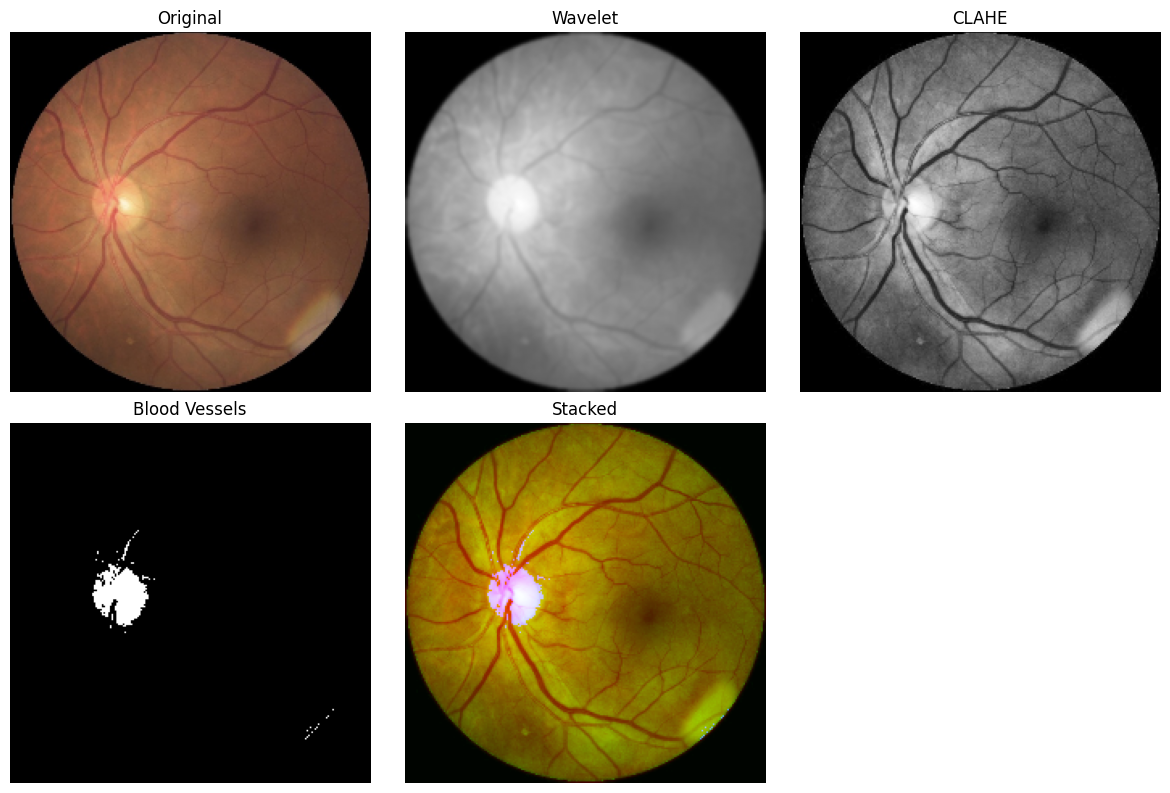

In [ ]:
def show_preprocessing_steps(class_name='normal'):
    # Choose a sample file from the preprocessed folder
    class_folder = os.path.join(original_data_path, class_name)
    sample_file = os.listdir(class_folder)[0]
    sample_path = os.path.join(class_folder, sample_file)

    image = cv2.imread(sample_path)
    image = cv2.resize(image, IMG_SIZE)
    wavelet = wavelet_transform(image)
    clahe = apply_clahe(image)
    vessel = blood_vessel_segmentation(image)
    stacked = np.stack([wavelet, clahe, vessel], axis=-1)

    # Display
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
    plt.subplot(2, 3, 2); plt.imshow(wavelet, cmap='gray'); plt.title("Wavelet"); plt.axis('off')
    plt.subplot(2, 3, 3); plt.imshow(clahe, cmap='gray'); plt.title("CLAHE"); plt.axis('off')
    plt.subplot(2, 3, 4); plt.imshow(vessel, cmap='gray'); plt.title("Blood Vessels"); plt.axis('off')
    plt.subplot(2, 3, 5); plt.imshow(stacked.astype('uint8')); plt.title("Stacked"); plt.axis('off')
    plt.tight_layout()
    plt.show()

show_preprocessing_steps('normal')


In [ ]:
def load_stacked_images(preprocessed_path):
    X = []
    y = []
    class_map = {c: i for i, c in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(preprocessed_path, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.npy'):
                arr = np.load(os.path.join(class_dir, file))
                X.append(arr)
                y.append(class_map[class_name])

    return np.array(X), np.array(y)

# Load from saved .npy files
X_data, y_data = load_stacked_images(save_path)


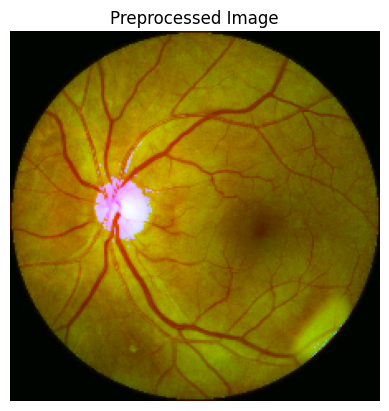

In [ ]:
import numpy as np
import os
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dataset directory containing preprocessed images (npy files)
dataset_dir = '/content/drive/MyDrive/eye_diseases_classification/preprocessed_stacked'

# Image size for the model (e.g., 224x224 for VGG)
IMG_SIZE = (224, 224)

# Function to load and preprocess preprocessed image
def load_preprocessed_image(image_path):
    # Load preprocessed .npy image
    image = np.load(image_path)
    # Ensure the image is the correct shape (2D or 3D as needed)
    if len(image.shape) == 2:  # grayscale image
        image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return cv2.resize(image, IMG_SIZE)

# Example for a single image path (testing loading)
example_img_path = '/content/drive/MyDrive/eye_diseases_classification/preprocessed_stacked/normal/1034_left.npy'
preprocessed_image = load_preprocessed_image(example_img_path)

# Display the preprocessed image to verify it's correctly loaded
plt.imshow(preprocessed_image.squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()





In [ ]:
# Create a simple data generator for loading and batching preprocessed images
def load_data_from_npy(dataset_dir):
    images = []
    labels = []

    class_names = os.listdir(dataset_dir)
    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith(".npy"):
                    img_path = os.path.join(class_dir, filename)
                    image = load_preprocessed_image(img_path)  # Load preprocessed image
                    images.append(image)
                    labels.append(class_names.index(class_name))  # Label is the class index

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load the full dataset
X_data, y_data = load_data_from_npy(dataset_dir)

# Check shape of the dataset
print("Training data shape:", X_data.shape)  # Should be (num_samples, 224, 224, channels)
print("Labels shape:", y_data.shape)



Training data shape: (4217, 224, 224, 3)
Labels shape: (4217,)


In [ ]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)



vgg19

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Assuming classes is already defined
num_classes = len(classes)

# Load your data from .npy files
X_data, y_data = load_stacked_images(dataset_dir)

# Normalize the input data
X_data = X_data.astype('float32') / 255.0

# One-hot encode the labels
y_data = to_categorical(y_data, num_classes=num_classes)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Define the input shape
input_shape = (224, 224, 3)

# Load the base VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine into final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

# Save the model
model.save('/content/drive/MyDrive/eye_diseases_classification/vgg19_eye_disease_model.h5')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,189,124 (77.02 MB)

 Trainable params: 164,740 (643.52 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


106/106 ━━━━━━━━━━━━━━━━━━━━ 64s 464ms/step - accuracy: 0.4222 - loss: 1.3206 - val_accuracy: 0.6114 - val_loss: 1.0911
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - accuracy: 0.6344 - loss: 1.0606 - val_accuracy: 0.6540 - val_loss: 0.8905
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 264ms/step - accuracy: 0.6600 - loss: 0.8945 - val_accuracy: 0.7014 - val_loss: 0.7836
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 306ms/step - accuracy: 0.6914 - loss: 0.7961 - val_accuracy: 0.7180 - val_loss: 0.7243
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.7243 - loss: 0.7352 - val_accuracy: 0.7275 - val_loss: 0.6737
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 262ms/step - accuracy: 0.7309 - loss: 0.6933 - val_accuracy: 0.7441 - val_loss: 0.6488
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 307ms/step - accuracy: 0.7539 - loss: 0.6584 - val_accuracy: 0.7464 - val_loss: 0.6211
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.7613 - loss: 0.6300 - val

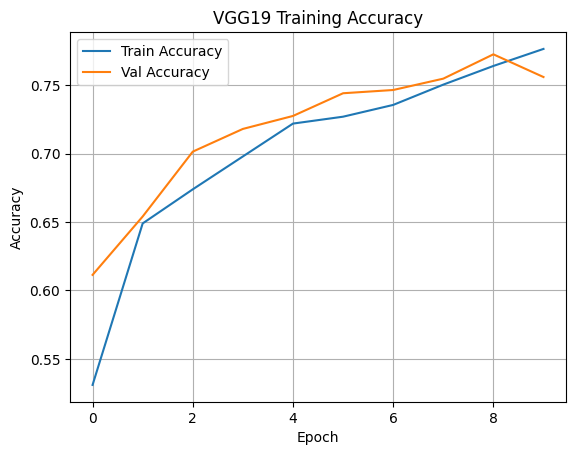

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG19 Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

# Safety batch size for Colab
BATCH_SIZE = 16
EPOCHS = 15

# Convert numpy arrays to TensorFlow datasets (better memory handling)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Shuffle and batch
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Freeze first layers, fine-tune later layers
fine_tune_at = 17
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Custom callback to show accuracy
class AccuracyPrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Train Acc = {logs['accuracy']:.4f}, Val Acc = {logs['val_accuracy']:.4f}")

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/eye_diseases_classification/vgg19_finetuned_best_model.h5',
                    monitor='val_accuracy', save_best_only=True, verbose=1),
    AccuracyPrinter()
]

# Fine-tuning with stable training loop
fine_tune_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=0  # We handle printing manually
)



Epoch 1: val_accuracy improved from -inf to 0.85545, saving model to /content/drive/MyDrive/eye_diseases_classification/vgg19_finetuned_best_model.h5


Epoch 1: Train Acc = 0.8194, Val Acc = 0.8555

Epoch 2: val_accuracy improved from 0.85545 to 0.87085, saving model to /content/drive/MyDrive/eye_diseases_classification/vgg19_finetuned_best_model.h5


Epoch 2: Train Acc = 0.8645, Val Acc = 0.8709

Epoch 3: val_accuracy improved from 0.87085 to 0.87322, saving model to /content/drive/MyDrive/eye_diseases_classification/vgg19_finetuned_best_model.h5


Epoch 3: Train Acc = 0.8959, Val Acc = 0.8732

Epoch 4: val_accuracy improved from 0.87322 to 0.88033, saving model to /content/drive/MyDrive/eye_diseases_classification/vgg19_finetuned_best_model.h5


Epoch 4: Train Acc = 0.9087, Val Acc = 0.8803

Epoch 5: val_accuracy did not improve from 0.88033
Epoch 5: Train Acc = 0.9170, Val Acc = 0.8756

Epoch 6: val_accuracy did not improve from 0.88033
Epoch 6: Train Acc = 0.9339, Val Acc = 0.8803

Epoch 7: val_accuracy improved from 0.88033 to 0.88152, saving model to /content/drive/MyDrive/eye_diseases_classification/vgg19_finetuned_best_model.h5


Epoch 7: Train Acc = 0.9410, Val Acc = 0.8815

Epoch 8: val_accuracy improved from 0.88152 to 0.88863, saving model to /content/drive/MyDrive/eye_diseases_classification/vgg19_finetuned_best_model.h5


Epoch 8: Train Acc = 0.9463, Val Acc = 0.8886

Epoch 9: val_accuracy did not improve from 0.88863
Epoch 9: Train Acc = 0.9570, Val Acc = 0.8815

Epoch 10: val_accuracy did not improve from 0.88863
Epoch 10: Train Acc = 0.9600, Val Acc = 0.8673

Epoch 11: val_accuracy did not improve from 0.88863
Epoch 11: Train Acc = 0.9641, Val Acc = 0.8839

Epoch 12: val_accuracy did not improve from 0.88863
Epoch 12: Train Acc = 0.9748, Val Acc = 0.8851


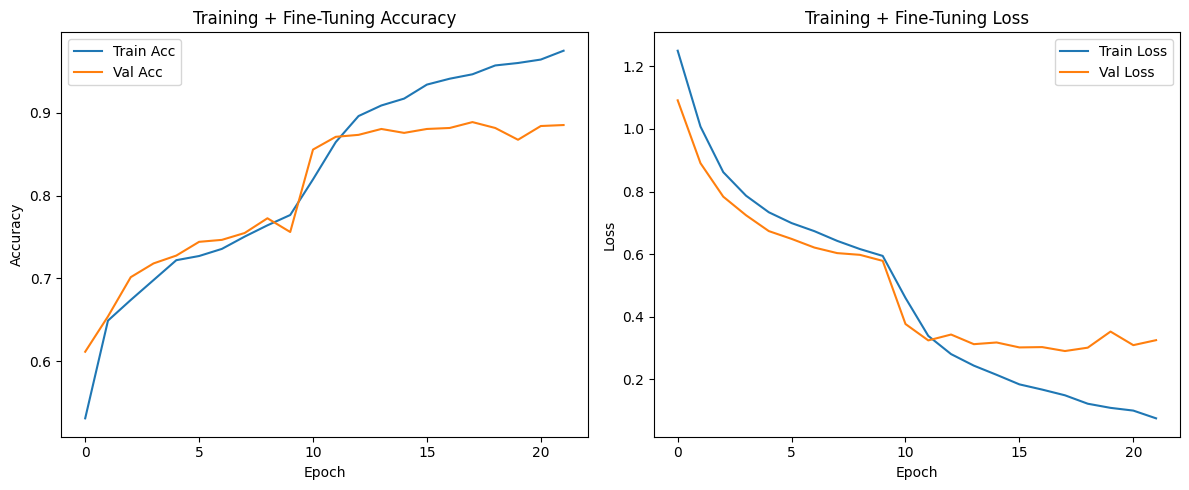

In [ ]:
# Combine history from initial training + fine-tuning
def plot_combined_history(initial, finetune):
    acc = initial.history['accuracy'] + finetune.history['accuracy']
    val_acc = initial.history['val_accuracy'] + finetune.history['val_accuracy']
    loss = initial.history['loss'] + finetune.history['loss']
    val_loss = initial.history['val_loss'] + finetune.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Training + Fine-Tuning Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Training + Fine-Tuning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_combined_history(history, fine_tune_history)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step


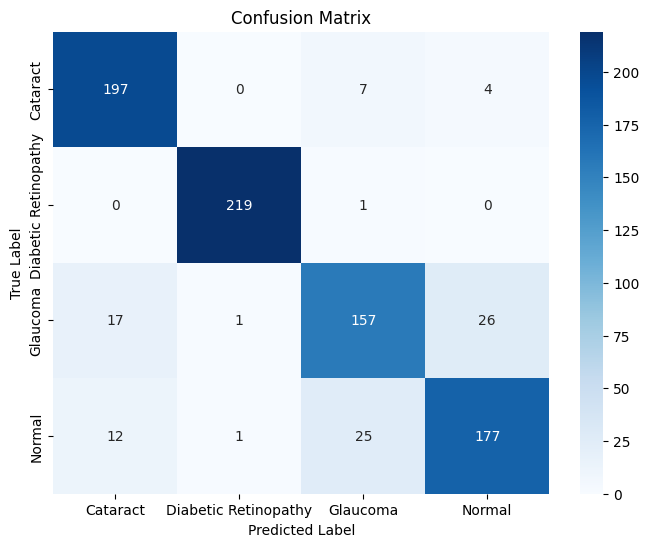

Classification Report:

                      precision    recall  f1-score   support

            Cataract       0.87      0.95      0.91       208
Diabetic Retinopathy       0.99      1.00      0.99       220
            Glaucoma       0.83      0.78      0.80       201
              Normal       0.86      0.82      0.84       215

            accuracy                           0.89       844
           macro avg       0.89      0.89      0.89       844
        weighted avg       0.89      0.89      0.89       844



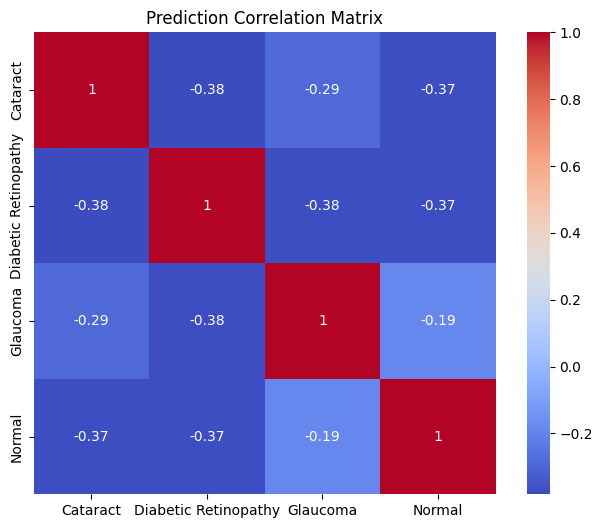

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd # Import the pandas library

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Classification Report ---
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

# --- Correlation Matrix of Predictions ---
# Convert one-hot to raw probabilities, then compute correlation
pred_probs_df = pd.DataFrame(y_pred_probs, columns=class_labels) # Use pd alias to access DataFrame
corr_matrix = pred_probs_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Prediction Correlation Matrix")
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step


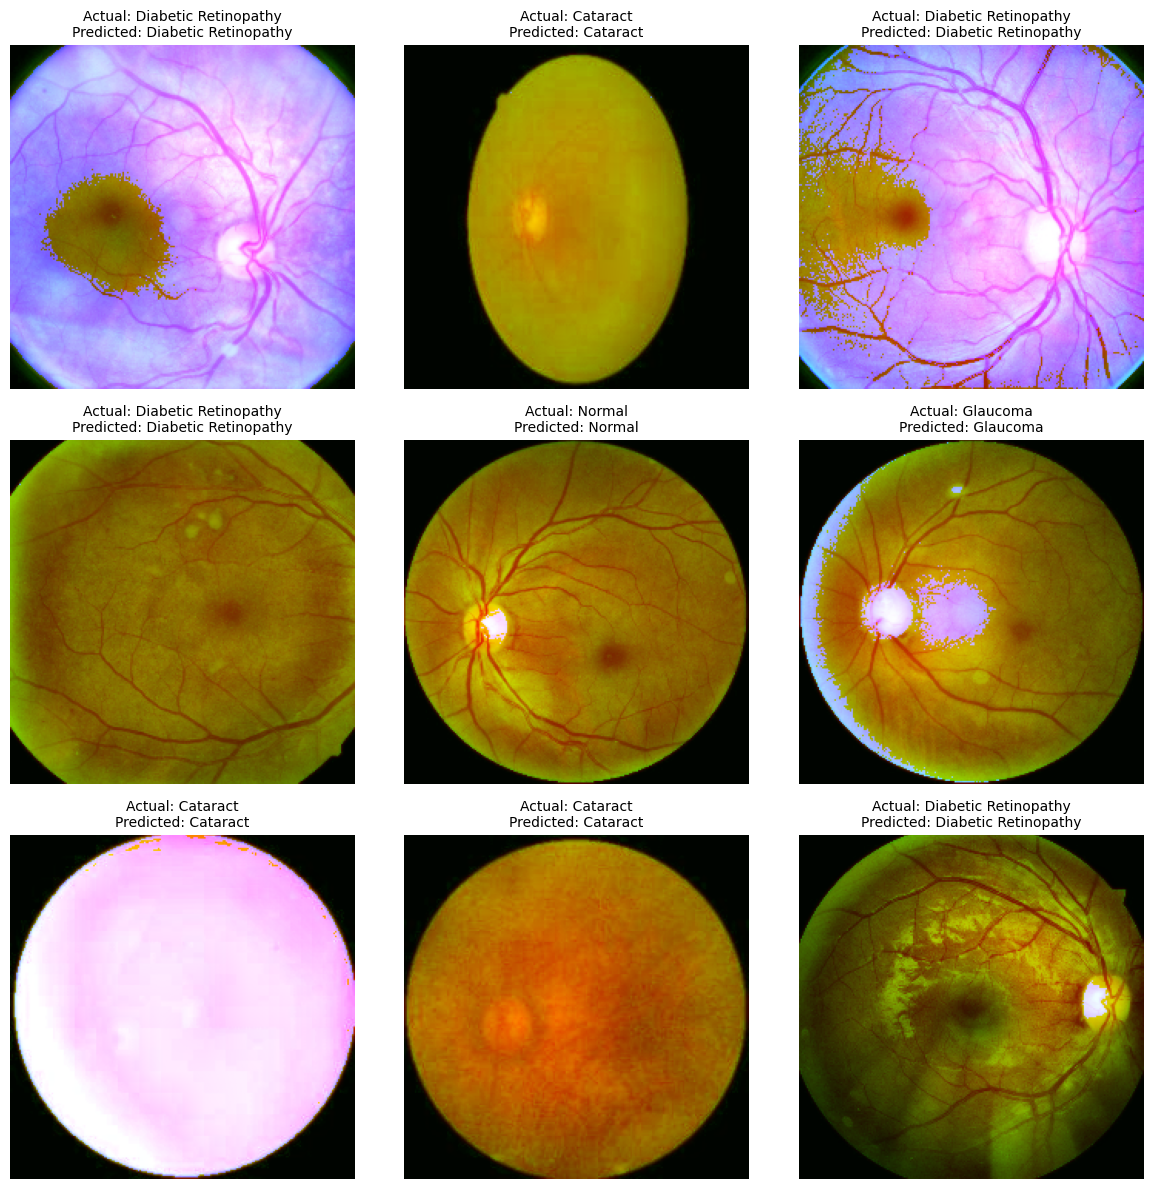

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_actual_vs_predicted(model, X_data, y_data, class_labels, num_samples=9):
    # Predict the labels for the test set
    y_pred_probs = model.predict(X_data)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_data, axis=1)

    # Show predictions
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)

        # Normalize image for display if needed
        img = X_data[i]
        if img.max() > 1:
            img = img / 255.0

        plt.imshow(img)
        actual = class_labels[y_true_classes[i]]
        predicted = class_labels[y_pred_classes[i]]
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use on validation or test data
class_labels = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']
display_actual_vs_predicted(model, X_val, y_val, class_labels)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step


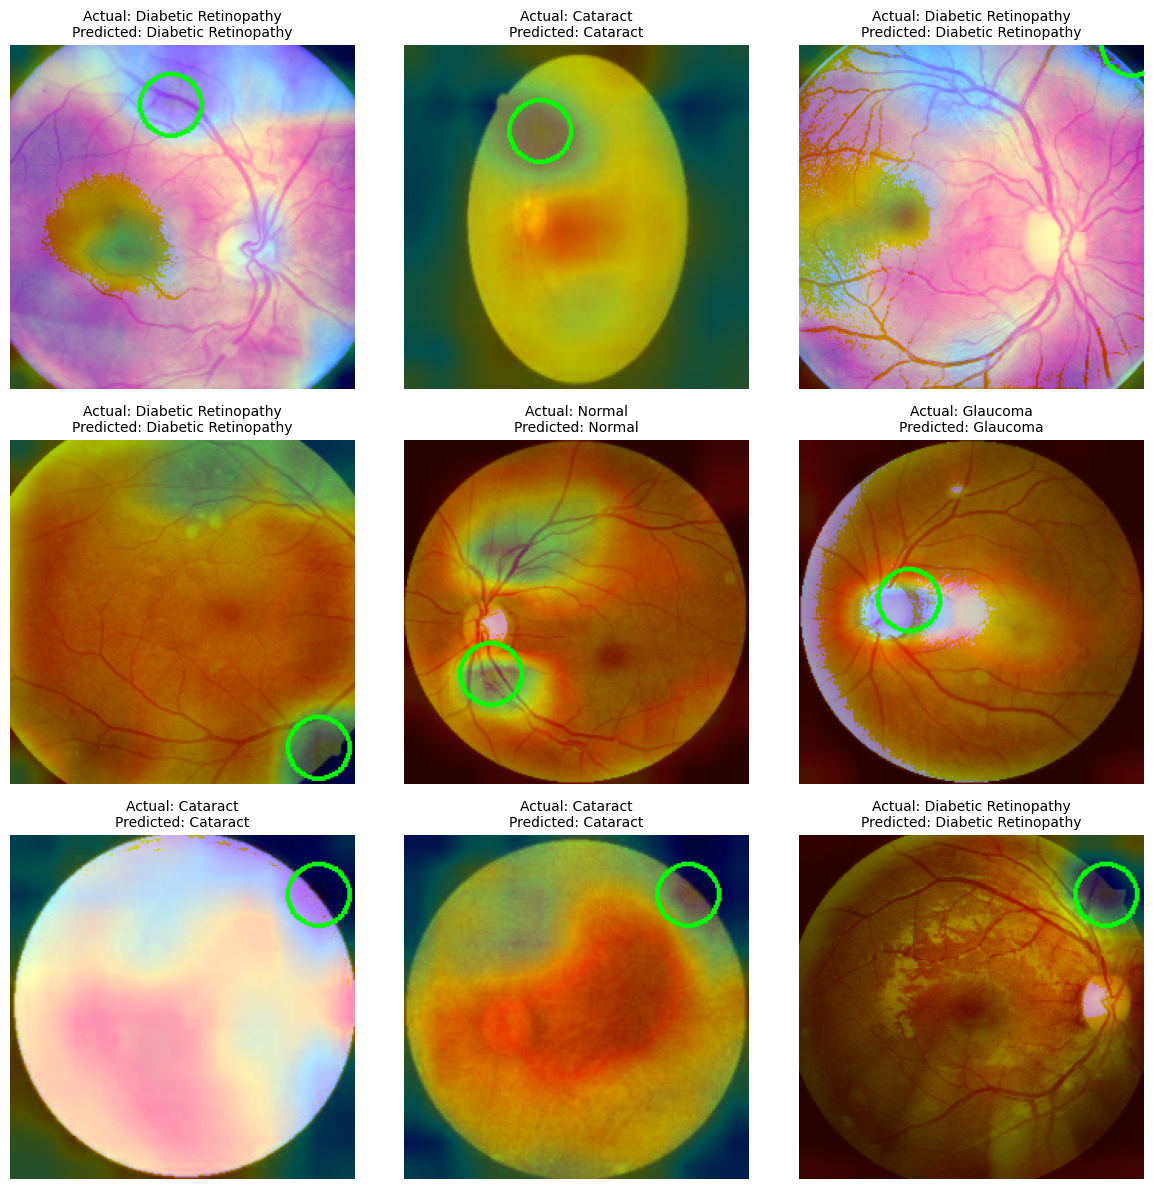

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

# Grad-CAM Heatmap Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]
    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Display Function with Heatmap and Circle Highlight
def display_actual_vs_predicted(model, X_data, y_data, class_labels, num_samples=9, last_conv_layer_name='block5_conv4'):
    y_pred_probs = model.predict(X_data)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_data, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)

        img = X_data[i]
        if img.max() > 1:
            img = img / 255.0

        # Get Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=y_pred_classes[i])
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(np.uint8(img * 255), 0.7, heatmap_color, 0.3, 0)

        # Find max heat location and draw a circle
        max_loc = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)
        cv2.circle(superimposed_img, max_loc[::-1], 20, (0, 255, 0), 2)  # Green circle

        plt.imshow(superimposed_img)
        actual = class_labels[y_true_classes[i]]
        predicted = class_labels[y_pred_classes[i]]
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
class_labels = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']
display_actual_vs_predicted(model, X_val, y_val, class_labels)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
<ipython-input-27-b456f08e88ed>:46: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


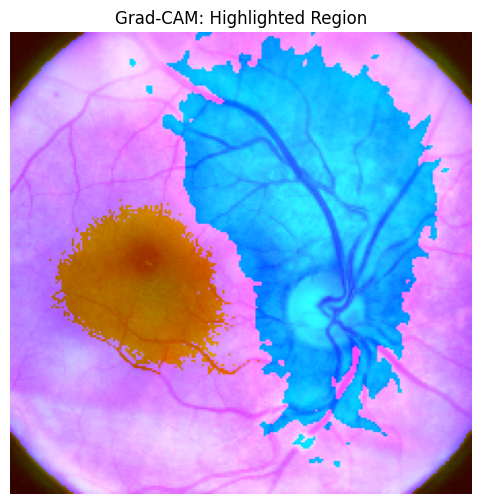

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
Predicted Class: Diabetic Retinopathy


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def get_img_array(img, size):
    """Prepares image for model prediction"""
    img = cv2.resize(img, size)
    img = np.expand_dims(img, axis=0)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations and prediction
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients of the predicted class wrt conv layer output
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of gradients across the feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with respect to the predicted class
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on original image
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM: Highlighted Region")
    plt.show()

# --- Use the functions on an image from X_val ---
# Pick any image from your validation set
idx = 0  # change index to try different examples
original_img = (X_val[idx] * 255).astype(np.uint8)  # convert back if normalized
img_array = get_img_array(original_img, size=(224, 224))

# Class labels
class_labels = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']

# Get heatmap
last_conv_layer_name = 'block5_conv4'  # last conv layer in VGG19
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap over original image
save_and_display_gradcam(original_img, heatmap)

# Also show prediction
pred = np.argmax(model.predict(img_array), axis=1)[0]
print(f"Predicted Class: {class_labels[pred]}")
